# 0. Load and Explore Data

## 0.1. Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import yaml
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt

from torch_geometric.data import Data

from time import time as tt

/global/homes/d/danieltm/.conda/envs/gnn4na/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Load an example event and process so it is sensible
2. Visualize the event
3. Define a sense of "truth" 
4. Visualize some histograms of different features vs. their truth
5. Define a Data object with these features and truth

## 0.2. Load Data

In [12]:
input_dir = "/global/cfs/cdirs/m3443/data/NA63/Datasets/Simulation/Raw"

In [13]:
# Read csv with column name "layer_0"
layer0 = pd.read_csv(os.path.join(input_dir, "EventDataFileMimosa0TridentTrackReconstructionTest.txt"), header=None, names=["layer_0"])

In [13]:
# Read csv with column name "layer_0"
layer7 = pd.read_csv(os.path.join(input_dir, "EventDataFileMimosa7TridentTrackReconstructionTest.txt"), header=None, names=["layer_7"])

1. Want to load all layers, then loop over each event
2. Start with a single event

In [4]:
layers = []
for i in tqdm(range(8)):
    layers.append(pd.read_csv(os.path.join(input_dir, f"EventDataFileMimosa{i}TridentTrackReconstructionTest.txt"), header=None, names=[f"layer_{i}"]))

100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


In [5]:
layers = pd.concat(layers, axis=1)

In [6]:
event = layers.iloc[0]

In [7]:
node_array = np.array(event[f"layer_{3}"].strip().split("\t")[1:], dtype=np.float32).reshape(-1, 4)
# Concat integer multiplicity to the last column of node_array
node_array = np.concatenate([node_array, np.ones((node_array.shape[0], 1), dtype=np.float32)], axis=1)

In [9]:
nodes = []
for i in range(8):
    layer_hits = event[f"layer_{i}"].strip().split("\t")
    num_hits = int(layer_hits[0])
    if num_hits > 0:
        node_array = np.array(layer_hits[1:], dtype=np.float32).reshape(-1, 4)
        # Concat i to the last column of node_array
        node_array = np.concatenate([node_array, i * np.ones((node_array.shape[0], 1), dtype=np.float32)], axis=1)
        nodes.append(node_array)
nodes = np.concatenate(nodes, axis=0)

In [13]:
event_data = Data(x=torch.tensor(nodes, dtype=torch.float))

In [14]:
event_data

Data(x=[10, 5])

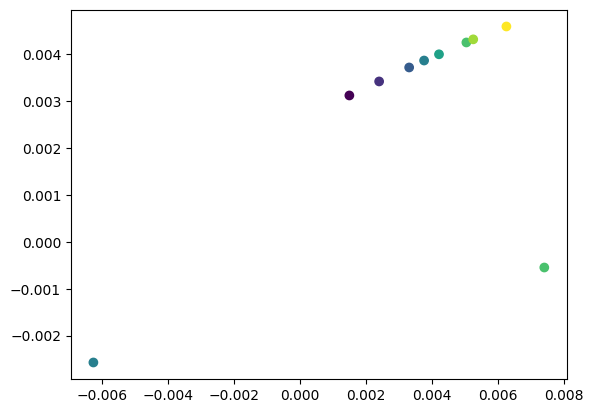

In [16]:
plt.scatter(event_data.x[:, 0], event_data.x[:, 1], c=event_data.x[:, 4])

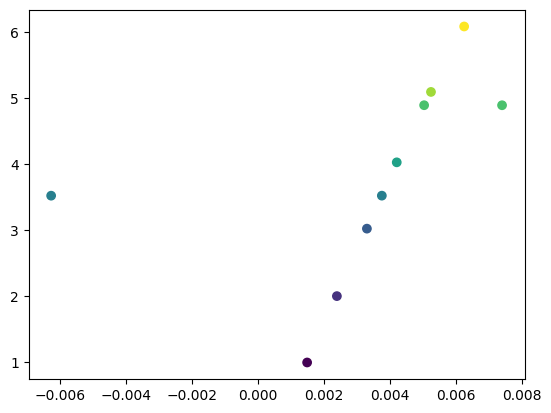

In [18]:
plt.scatter(event_data.x[:, 0], event_data.x[:, 2], c=event_data.x[:, 4])

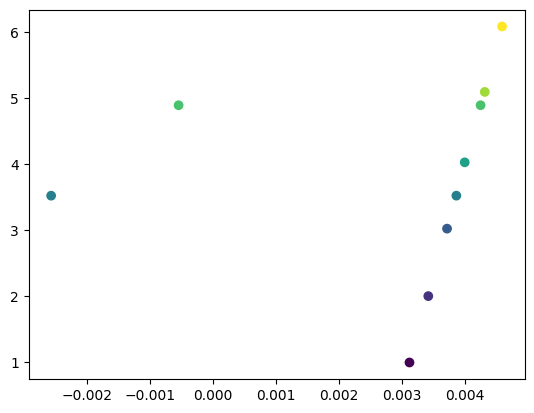

In [19]:
plt.scatter(event_data.x[:, 1], event_data.x[:, 2], c=event_data.x[:, 4])

Text(0.5, 0, 'z')

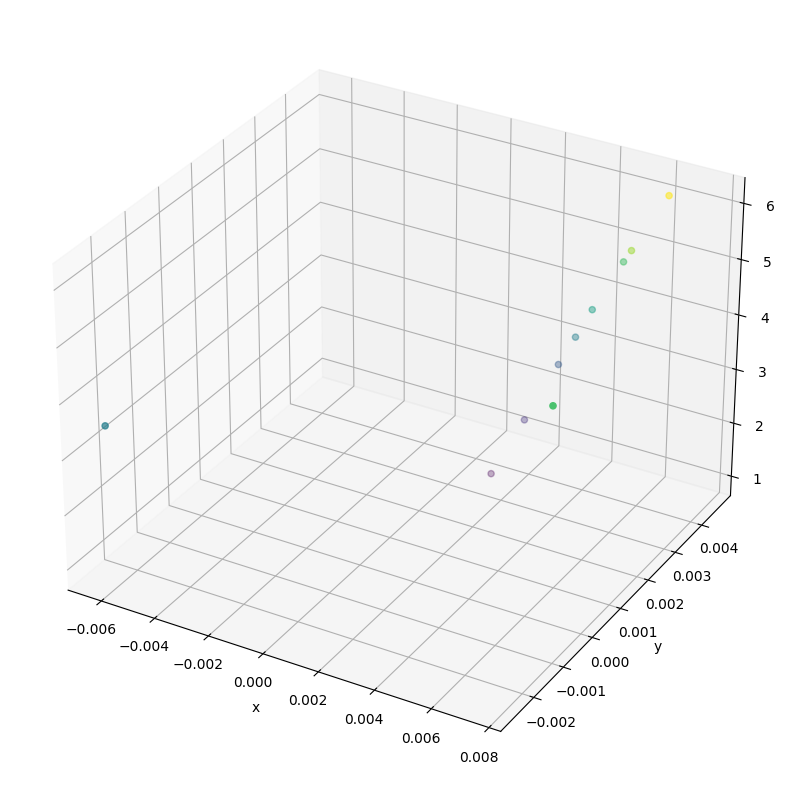

In [24]:
#Scatter 3d with axis labels
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(event_data.x[:, 0], event_data.x[:, 1], event_data.x[:, 2], c=event_data.x[:, 4])
ax.set_xlabel('x')
ax.set_ylabel('y')


## 0.3 Define a sense of "truth"

In [34]:
truth_df = pd.read_csv(os.path.join(input_dir, "TridentTypeInEventTridentTrackReconstructionTest.txt"), header=None)

In [45]:
truth_df.iloc[1421][0].strip().split("\t")

['1', '5']

In [46]:
truth_df.iloc[1422][0].strip().split("\t")

['0']

In [51]:
events = []
# Loop over rows in layers
for i in tqdm(range(len(layers))):
    event = layers.iloc[i]
    nodes = []
    # Loop over layers
    for j in range(8):
        layer_hits = event[f"layer_{j}"].strip().split("\t")
        num_hits = int(layer_hits[0])
        if num_hits > 0:
            node_array = np.array(layer_hits[1:], dtype=np.float32).reshape(-1, 4)
            # Concat j to the last column of node_array
            node_array = np.concatenate([node_array, j * np.ones((node_array.shape[0], 1), dtype=np.float32)], axis=1)
            nodes.append(node_array)
    truth = truth_df.iloc[i][0].strip().split("\t")
    if len(truth) > 1:
        truth = torch.tensor(int(truth[1])).long()
    else:
        truth = torch.tensor(int(truth[0])).long()
    event_data = Data(x=torch.tensor(np.concatenate(nodes, axis=0), dtype=torch.float), y=truth)
    events.append(event_data)

100%|██████████| 1000000/1000000 [03:42<00:00, 4496.38it/s]


In [52]:
# Save events to a file
torch.save(events, os.path.join(input_dir, "events.pt"))

## 0.4 Load and Inspect Processed Data

An event is a PyG Data object, with `x` and `y` features.

`x` is the input features, composed of:
1. The `x` position
2. The `y` position
3. The `z` position
4. The particle information (which should not be used in the model)
5. The layer number of that hit

`y` is the truth feature, where if `0` indicates that there was no trident event, and if greater than `0` indicates the type of trident event.

In [5]:
save_dir = "/global/cfs/cdirs/m3443/data/NA63/Datasets/Simulation/Processed"
chunk_save_dir = os.path.join(save_dir, "Chunked")

In [3]:
%%time
all_events = torch.load(os.path.join(save_dir, "events.pt"))

CPU times: user 1min 36s, sys: 2.2 s, total: 1min 38s
Wall time: 1min 39s


In [4]:
sample = all_events[0]

In [5]:
sample

Data(x=[10, 5], y=0)

In [6]:
len(all_events)

1000000

In [8]:
# Chunk events for quick loading
chunk_size = 100000
num_chunks = len(all_events) // chunk_size
for i in tqdm(range(num_chunks)):
    torch.save(all_events[i*chunk_size:(i+1)*chunk_size], os.path.join(chunk_save_dir, f"events_chunk_{i}.pt"))

100%|██████████| 10/10 [01:13<00:00,  7.36s/it]


In [6]:
%%time
events = torch.load(os.path.join(chunk_save_dir, "events_chunk_0.pt"))

CPU times: user 10.2 s, sys: 224 ms, total: 10.4 s
Wall time: 10.4 s


In [7]:
len(events)

100000

In [8]:
sample = events[0]

In [9]:
sample

Data(x=[10, 5], y=0)

In [20]:
# Plot an event, with the layer and targets information
def plot_event_2d(event):
    layers_z = [0, 1.0, 2.0, 2.5, 3.0, 3.9, 4.1, 5.1]
    targets_z_x = [[1.3, 0], [3.6, 0]]
    targets_z_y = [[1.3, 0], [3.6, 0]]

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(event.x[:, 2], event.x[:, 0])
    ax[0].set_xlabel("z")
    ax[0].set_ylabel("x")
    ax[0].set_title("x vs z")

    ax[1].scatter(event.x[:, 2], event.x[:, 1])
    ax[1].set_xlabel("z")
    ax[1].set_ylabel("y")
    ax[1].set_title("y vs z")

    for i in range(8):
        ax[0].axvline(x=layers_z[i], color="r")
        ax[1].axvline(x=layers_z[i], color="r")

    for i in range(2):
        ax[0].scatter(targets_z_x[i][0], targets_z_x[i][1], color="g", s=100)
        ax[1].scatter(targets_z_y[i][0], targets_z_y[i][1], color="g", s=100)

    # Add truth information into plot as text
    truth = event.y
    if truth == 0:
        truth = "No Trident"
    else:
        truth = "Trident"
    ax[0].text(0.05, 0.95, truth, transform=ax[0].transAxes, fontsize=14, verticalalignment='top')
    ax[1].text(0.05, 0.95, truth, transform=ax[1].transAxes, fontsize=14, verticalalignment='top')

    plt.show()

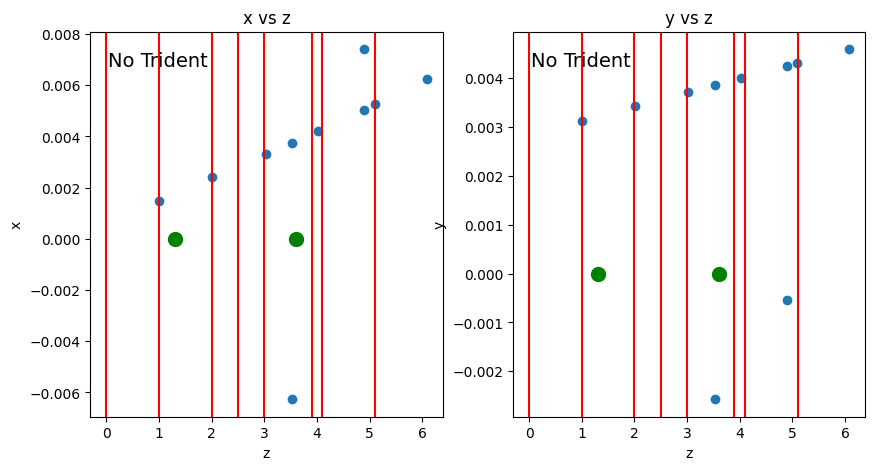

In [21]:
plot_event_2d(sample)

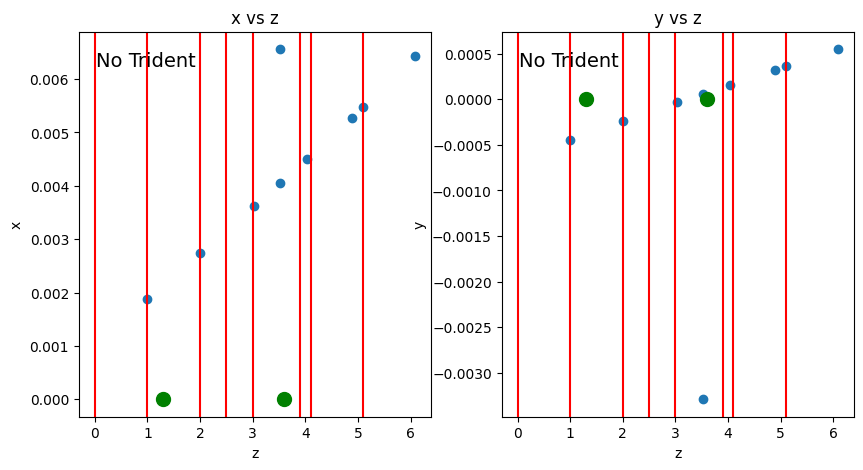

In [22]:
plot_event_2d(events[1])

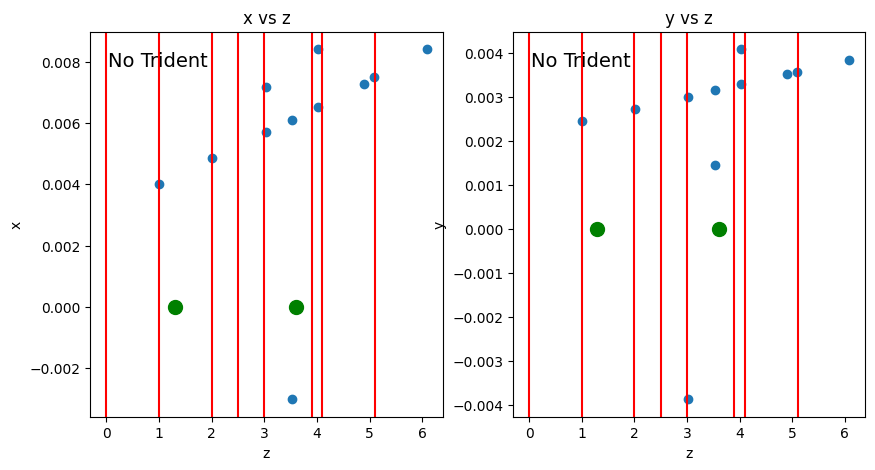

In [29]:
plot_event_2d(events[2])

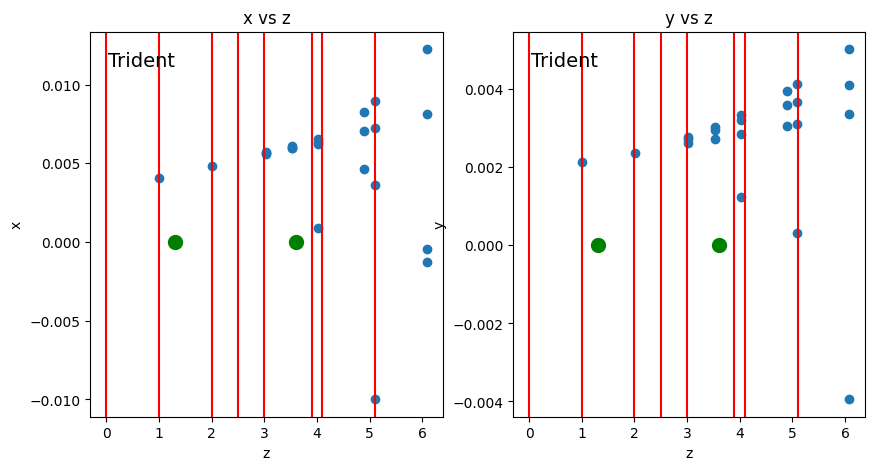

In [28]:
plot_event_2d(events[1421])